# Quantum Time Series Analysis: Serial Model
Compatible with Qiskit 1.02+

### Author
- **Jacob Cybulski**, jacob.cybulski[at]deakin.edu.au<br/>
    Enquanted, Melbourne, Vic, Australia

### Date
- Nov 2024: Compatibility upgrade to Qiskit 1.2.4 

### Aims
> *This script aims to demonstrate what a model can learn*

In [1]:
import sys
sys.path.append('.')

In [2]:
import os
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
### Libraries used in QAE development

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA, NELDER_MEAD, SPSA, ADAM, L_BFGS_B
from qiskit.circuit.library import RealAmplitudes, TwoLocal, ZFeatureMap, ZZFeatureMap
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit.visualization import plot_histogram, plot_state_city, plot_state_paulivec
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit.circuit import Parameter

## Create a serial model to fit data

### Identify device

In [4]:
### Find what devices are available
from qiskit_aer import Aer
from qiskit_aer.backends import AerSimulator
devices = AerSimulator().available_devices()
print(f'Available quantum devices: {devices}')

### Priority GPU
device = 'GPU' if ('GPU' in devices) else 'CPU'

### Force CPU for this run
device = 'CPU'
device
print(f'Selected device: {device}')

Available quantum devices: ('CPU', 'GPU')
Selected device: CPU


In [5]:
### Create a sampler/estimator suitable for the device
#   GPU methods: statevector, tensor_network, density_matrix, unitary

from qiskit.primitives import Sampler, Estimator # For "CPU", ignores device="GPU" option
from qiskit_aer.primitives import Sampler as AerSampler, Estimator as AerEstimator # For device="GPU" option

seed = 2022
shots = 10000

if device == 'GPU':
    sampler = AerSampler(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': shots},
        transpile_options={'seed_transpiler': seed},
    )
    
    estimator = AerEstimator(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': shots},
        transpile_options={'seed_transpiler': seed},
    )
else:
    sampler = Sampler()
    estimator = Estimator()

### Create a serial model and test it

ParameterView([Parameter(W[000]), Parameter(W[001]), Parameter(W[002]), Parameter(W[003]), Parameter(W[004]), Parameter(W[005]), Parameter(W[006]), Parameter(W[007]), Parameter(W[008]), Parameter(W[009]), Parameter(W[010]), Parameter(W[011]), Parameter(W[012]), Parameter(W[013]), Parameter(W[014]), Parameter(W[015]), Parameter(W[016]), Parameter(W[017]), Parameter(X)])




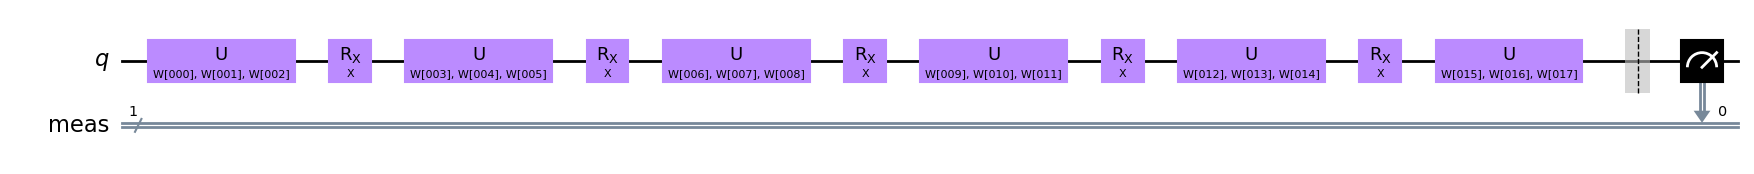

In [6]:
### Create a custom serial model circuit 
#   - To be used with CircuitQNN / NeuralNetworkRegressor

def serial_fourier_model(layers, add_meas=False):
    
    ansatz = QuantumCircuit(1, name="ansatz")
    param_x = Parameter('X')
    pno = 0 # Variational parameter counter
    params = []

    # Data encoding block
    def S():
        ansatz.rx(param_x, 0)

    # Trainable variational block
    def W(layer, label):
        nonlocal pno
        nonlocal params
        param_w_0 = Parameter(f'{label}[{pno:03d}]')
        param_w_1 = Parameter(f'{label}[{pno+1:03d}]')
        param_w_2 = Parameter(f'{label}[{pno+2:03d}]')
        params += [param_w_0, param_w_1, param_w_2]
        ansatz.u(param_w_0, param_w_1, param_w_2, 0)
        pno += 3

    # Create layers of W, S blocks
    for l in range(layers):
        W(l, 'W')
        S()

    # Add the final block
    W(layers, 'W')

    if add_meas:
        ansatz.measure_all()

    # Create a parameter list
    params += [param_x]

    return ansatz 

# Show a sample serial model with the specified number of layers
m = serial_fourier_model(5, add_meas=True)

# Show all parameters, the last is X
print(m.parameters)
print()

# Show the circuit
m.draw(output='mpl', style='clifford', scale=1, fold=True)
print()

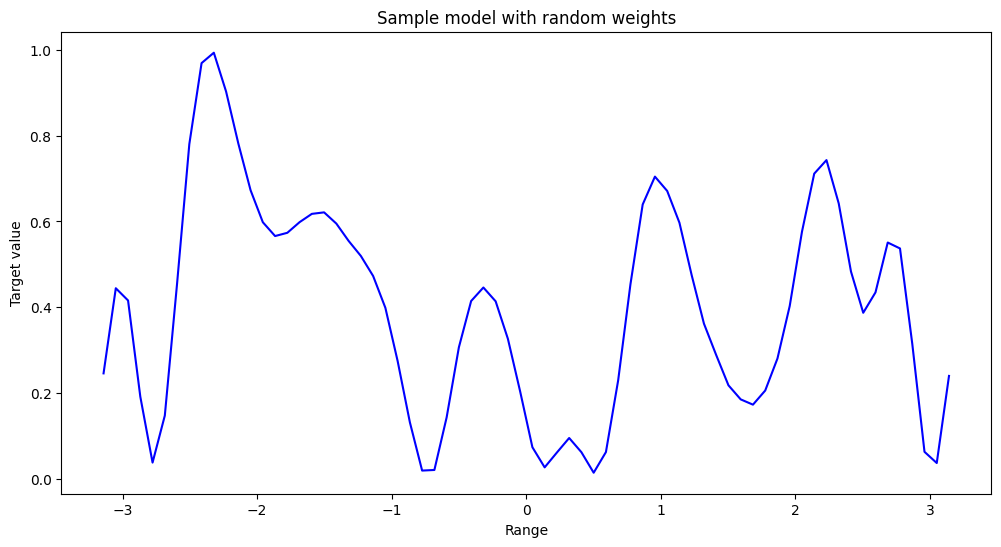

In [7]:
### Test a model
#   - Note that when layers=1 it will always generate a sine/cosine function
#   - Without a random seed it will produce a different function every time

# Start the random process, or remove to have a different shape each time
# algorithm_globals.random_seed = seed

# Define the ansatz architecture and prepare X, y vectors
layers = 27
x_vect = np.linspace(-np.pi, np.pi, 70)
y_vect = []

# Initialise all parameters to random values (X is last)
param_vals = algorithm_globals.random.random((layers+1)*3+1) * 2 * np.pi

# Use ansatz to generate x, y pairs
for x in x_vect:
    
    # Create a circuit for each new value of x
    model = serial_fourier_model(layers, add_meas=True)
    param_vals[-1] = x
    init_weights = param_vals[:-1]
    model_inst = model.assign_parameters(param_vals)

    # Generate y as a frequency distribution based on quasi-probability of measuring '0'
    backend = Aer.get_backend('statevector_simulator') 
    result = sampler.run(model_inst, shots=shots).result()
    counts = result.quasi_dists[0]
    y_vect.append(counts[0])

# Plot the curve
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Sample model with random weights")
plt.xlabel("Range")
plt.ylabel("Target value")
plt.plot(x_vect, y_vect, color='blue')
plt.show()

## System details

In [8]:
!pip list | grep -e qiskit -e torch

qiskit                    1.2.4
qiskit-aer-gpu            0.15.1
qiskit-algorithms         0.3.1
qiskit-ibm-runtime        0.32.0
qiskit-machine-learning   0.7.2
qiskit-optimization       0.6.1
